In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'playground-series-s4e9:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F76728%2F9057646%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240917%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240917T145040Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D09f07d182d9da1c4b70225d0ef8e40aec9f636e5ded46cdfac65c7603024052aa656b68ebfc2619077a81c2384ab695fd4d99cb3b54dd2a0c8a1a81309daa17419ca3d25a33f7cffb755131df9bb76c91e032a3f2d516533e91ac98adc737105e70ba7138b0f86a100d702cb0c6b890abeee8c49063819c3e8aab1d9b917f01d9bd5afabb2406f413357cd04f684627af6bd8e1d79cd6fa53f201c110e9387b33a45c9c8619a1b9f87a505e429d1364ee56b4300c7542fead35c2769f1149b969db15de71d81bbdec1c7eff3bf5c190e64c29f4215e843e1a276107714ac9f0065183ab11936bd5e3b38be76a84fc02189cfbed394b8bcd93607d7f5e7991f74'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 8223535 bytes downloaded
Downloaded and uncompressed: playground-series-s4e9
Data source import complete.


In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/playground-series-s4e9/train.csv
/kaggle/input/playground-series-s4e9/test.csv
/kaggle/input/playground-series-s4e9/sample_submission.csv


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
pip install scikit-learn

In [ ]:
train_df = pd.read_csv('/kaggle/input/playground-series-s4e9/train.csv')
print(train_df.shape)
train_df.head()

(188533, 13)


,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


In [ ]:
test_df = pd.read_csv('/kaggle/input/playground-series-s4e9/test.csv')
print(test_df.shape)
test_df.head()

(125690, 12)


,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title
0,188533,Land,Rover LR2 Base,2015,98000,Gasoline,240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,6-Speed A/T,White,Beige,None reported,Yes
1,188534,Land,Rover Defender SE,2020,9142,Hybrid,395.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,8-Speed A/T,Silver,Black,None reported,Yes
2,188535,Ford,Expedition Limited,2022,28121,Gasoline,3.5L V6 24V PDI DOHC Twin Turbo,10-Speed Automatic,White,Ebony,None reported,NaN
3,188536,Audi,A6 2.0T Sport,2016,61258,Gasoline,2.0 Liter TFSI,Automatic,Silician Yellow,Black,None reported,NaN
4,188537,Audi,A6 2.0T Premium Plus,2018,59000,Gasoline,252.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,A/T,Gray,Black,None reported,Yes


# Exploratory Analysis

In [ ]:
y_train = train_df['price']
train_df = train_df.drop(['price'], axis=1)

In [ ]:
combined_df = pd.concat([train_df, test_df], axis=0, ignore_index=True)

print(combined_df.shape)
print(combined_df.head())

(314223, 12)
   id          brand              model  model_year  milage      fuel_type  \
0   0           MINI      Cooper S Base        2007  213000       Gasoline   
1   1        Lincoln              LS V8        2002  143250       Gasoline   
2   2      Chevrolet  Silverado 2500 LT        2002  136731  E85 Flex Fuel   
3   3        Genesis   G90 5.0 Ultimate        2017   19500       Gasoline   
4   4  Mercedes-Benz        Metris Base        2021    7388       Gasoline   

                                              engine  \
0       172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel   
1       252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel   
2  320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...   
3       420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel   
4       208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel   

                     transmission ext_col int_col  \
0                             A/T  Yellow    Gray   
1                             A/T  Silver   Beige   
2                     

In [ ]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 314223 entries, 0 to 314222
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            314223 non-null  int64 
 1   brand         314223 non-null  object
 2   model         314223 non-null  object
 3   model_year    314223 non-null  int64 
 4   milage        314223 non-null  int64 
 5   fuel_type     305757 non-null  object
 6   engine        314223 non-null  object
 7   transmission  314223 non-null  object
 8   ext_col       314223 non-null  object
 9   int_col       314223 non-null  object
 10  accident      310139 non-null  object
 11  clean_title   278565 non-null  object
dtypes: int64(3), object(9)
memory usage: 28.8+ MB


In [ ]:
combined_df.isnull().sum()

,0
id,0
brand,0
model,0
model_year,0
milage,0
fuel_type,8466
engine,0
transmission,0
ext_col,0
int_col,0


## NUMERICAL COLUMNS

In [ ]:
id = combined_df['id']
combined_df = combined_df.drop(['id'], axis=1)
print(combined_df.shape)

(314223, 11)


In [ ]:
num_df = combined_df.select_dtypes(include=np.number)
print('Numerical variables:')
print(num_df)

Numerical variables:
        model_year  milage
0             2007  213000
1             2002  143250
2             2002  136731
3             2017   19500
4             2021    7388
...            ...     ...
314218        2014   83315
314219        2019   29336
314220        2012   77634
314221        2012  112000
314222        2018   66840

[314223 rows x 2 columns]


### Distribution

model_year
Skew : -1.04


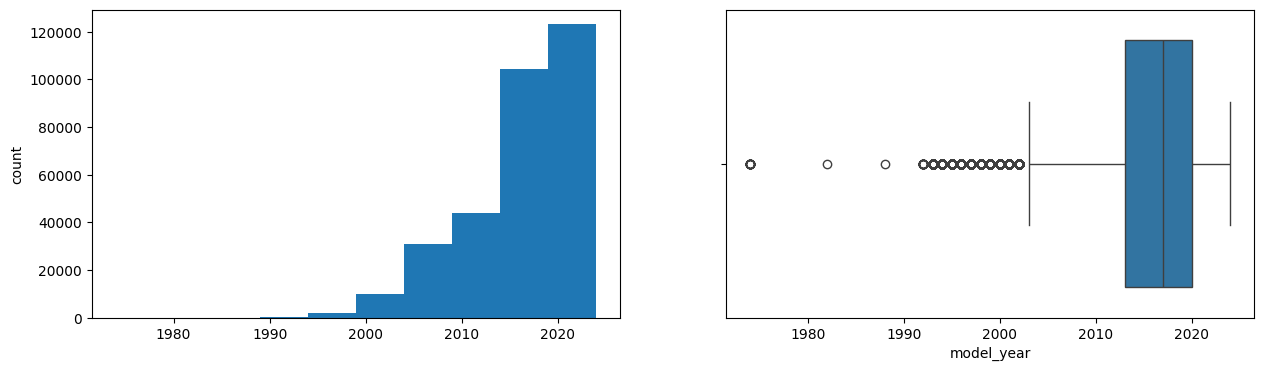

milage
Skew : 0.9


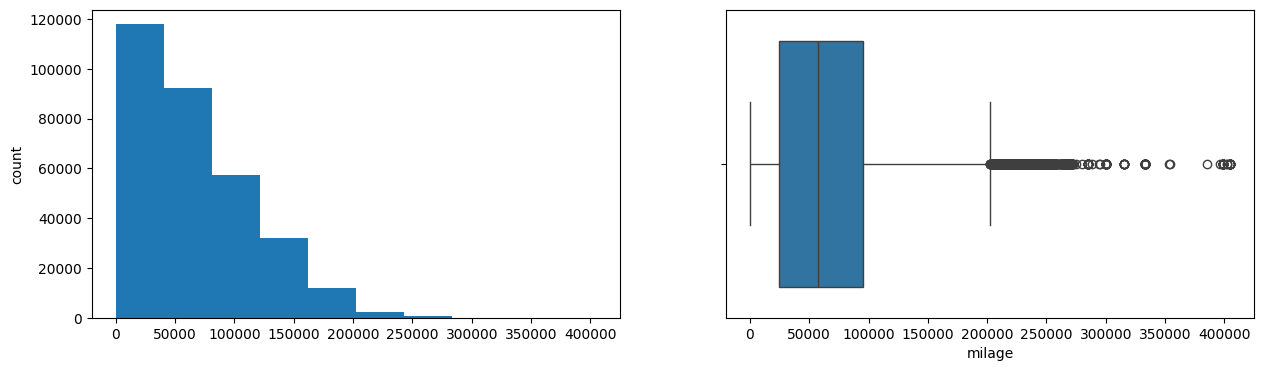

In [ ]:
for col in num_df:
    print(col)
    print('Skew :', round(num_df[col].skew(), 2))
    plt.figure(figsize = (15, 4))
    plt.subplot(1,2,1)
    num_df[col].hist(grid=False)
    plt.ylabel('count')
    plt.subplot(1, 2, 2)
    sns.boxplot(x=num_df[col])
    plt.show()

In [ ]:
num_df['log_mileage'] = np.log1p(num_df['milage'])
num_df = num_df.drop(['milage'], axis=1)

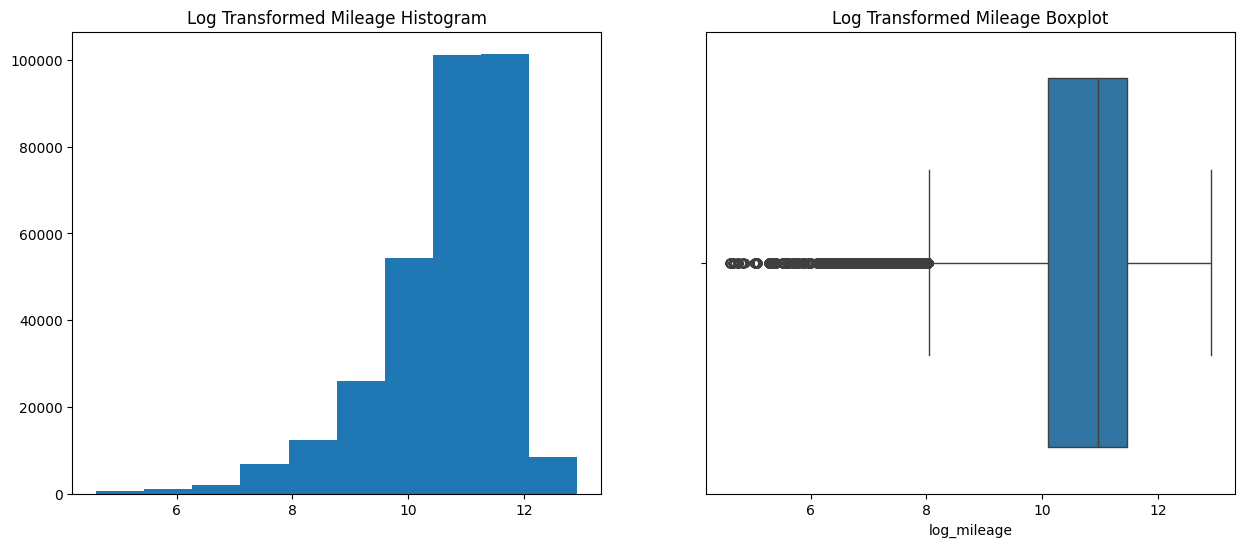

In [ ]:
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
num_df['log_mileage'].hist(grid=False)
plt.title('Log Transformed Mileage Histogram')

plt.subplot(1, 2, 2)
sns.boxplot(x=num_df['log_mileage'])
plt.title('Log Transformed Mileage Boxplot')

plt.show()

### Standardization

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

num_scaled = scaler.fit_transform(num_df)

In [ ]:
num_cols = ['model_year', 'log_mileage']
num_scaled = pd.DataFrame(num_scaled, columns = num_cols)

print(num_scaled.head())

   model_year  log_mileage
0        0.66     0.922547
1        0.56     0.874732
2        0.56     0.869118
3        0.86     0.634374
4        0.94     0.517401


### Correlation

In [ ]:
corr_matrix = num_scaled.corr()
print(corr_matrix)

             model_year  log_mileage
model_year     1.000000    -0.584272
log_mileage   -0.584272     1.000000


## CATEGORICAL COLUMNS

In [ ]:
cat_cols = combined_df.select_dtypes(include=['object'])
print(cat_cols)

                brand                   model      fuel_type  \
0                MINI           Cooper S Base       Gasoline   
1             Lincoln                   LS V8       Gasoline   
2           Chevrolet       Silverado 2500 LT  E85 Flex Fuel   
3             Genesis        G90 5.0 Ultimate       Gasoline   
4       Mercedes-Benz             Metris Base       Gasoline   
...               ...                     ...            ...   
314218  Mercedes-Benz  GL-Class GL 450 4MATIC       Gasoline   
314219           Audi          Q7 55 Prestige       Gasoline   
314220           Audi    A6 3.0T Premium Plus       Gasoline   
314221           Audi         Q7 3.0T Premium       Gasoline   
314222      Chevrolet                Tahoe LT       Gasoline   

                                                   engine  \
0            172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel   
1            252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel   
2       320.0HP 5.3L 8 Cylinder Engine Flex Fuel

### Missing Value

In [ ]:
cat_cols.isna().sum()

,0
brand,0
model,0
fuel_type,8466
engine,0
transmission,0
ext_col,0
int_col,0
accident,4084
clean_title,35658


In [ ]:
cat_cols['clean_title'] = cat_cols['clean_title'].fillna(0)

cat_cols['clean_title'] = cat_cols['clean_title'].apply(lambda x: 1 if x == 'Yes' else 0)

In [ ]:
cat_cols['fuel_type'] = cat_cols.groupby('model')['fuel_type'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'Unknown'))

In [ ]:
cat_cols['accident'] = cat_cols['accident'].apply(lambda x: 1 if x == 'At least 1 accident or damage reported'   ### change the imputation of missing values
                                                  else 0 if x == 'None reported'
                                                  else 2)

In [ ]:
cat_cols.isna().sum()

,0
brand,0
model,0
fuel_type,0
engine,0
transmission,0
ext_col,0
int_col,0
accident,0
clean_title,0


### Encoding

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
cat_cols.nunique()

,0
brand,57
model,1898
fuel_type,8
engine,1118
transmission,52
ext_col,319
int_col,156
accident,3
clean_title,2


In [ ]:
onehot_encoder = OneHotEncoder(sparse_output=False, drop='first')
low_cardinality_cols = ['fuel_type', 'transmission', 'brand']

onehot_encoded = onehot_encoder.fit_transform(cat_cols[low_cardinality_cols])

onehot_encoded_df = pd.DataFrame(onehot_encoded, columns=onehot_encoder.get_feature_names_out(low_cardinality_cols))
cat_cols = pd.concat([cat_cols.drop(columns=low_cardinality_cols), onehot_encoded_df], axis=1)

In [ ]:
high_cardinality_cols = ['model', 'engine', 'ext_col', 'int_col']

def frequency_encoding(df, column):
    freq_encoding = df[column].value_counts(normalize=True)
    return df[column].map(freq_encoding)

for col in high_cardinality_cols:
    cat_cols[col + '_freq_encoded'] = frequency_encoding(cat_cols, col)

In [ ]:
cat_cols = cat_cols.drop(columns=high_cardinality_cols)

## Merging of num_cols, cat_cols and id_train

In [ ]:
print(type(cat_cols))
print(type(num_scaled))
print(type(id))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


In [ ]:
print(cat_cols.shape)
print(num_scaled.shape)
print(id.shape)

(314223, 120)
(314223, 2)
(314223,)


In [ ]:
X = pd.concat([cat_cols, num_scaled, id], axis=1)

print(X.shape)
X.head()

(314223, 123)


,accident,clean_title,fuel_type_E85 Flex Fuel,fuel_type_Gasoline,fuel_type_Hybrid,fuel_type_Plug-In Hybrid,fuel_type_Unknown,fuel_type_not supported,fuel_type_–,transmission_1-Speed Automatic,...,brand_Volkswagen,brand_Volvo,brand_smart,model_freq_encoded,engine_freq_encoded,ext_col_freq_encoded,int_col_freq_encoded,model_year,log_mileage,id
0,0,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.003058,0.001878,0.005101,0.112598,0.66,0.922547,0
1,1,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000143,0.000426,0.090200,0.130449,0.56,0.874732,1
2,0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000372,0.004045,0.077245,0.112598,0.56,0.869118,2
3,0,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000506,0.000996,0.257868,0.570572,0.86,0.634374,3
4,0,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.002896,0.003704,0.257868,0.130449,0.94,0.517401,4


# SPLIT TRAIN AND TEST

In [ ]:
X_train = X[:188533]
X_test = X[188533:]

print(X_train.shape)
print(X_test.shape)

(188533, 123)
(125690, 123)


In [ ]:
id_train = X_train['id']
id_test = X_test['id']

X_train.drop(['id'], axis = 1)
X_test.drop(['id'], axis = 1)

,accident,clean_title,fuel_type_E85 Flex Fuel,fuel_type_Gasoline,fuel_type_Hybrid,fuel_type_Plug-In Hybrid,fuel_type_Unknown,fuel_type_not supported,fuel_type_–,transmission_1-Speed Automatic,...,brand_Toyota,brand_Volkswagen,brand_Volvo,brand_smart,model_freq_encoded,engine_freq_encoded,ext_col_freq_encoded,int_col_freq_encoded,model_year,log_mileage
188533,0,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000248,0.015492,0.232446,0.130449,0.82,0.828975
188534,0,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.001028,0.005038,0.090200,0.570572,0.92,0.543074
188535,0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.002944,0.009866,0.232446,0.009671,0.96,0.678499
188536,0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000455,0.003227,0.000099,0.570572,0.84,0.772341
188537,0,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.001254,0.005843,0.134277,0.570572,0.88,0.767814
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
314218,0,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.001999,0.005057,0.257868,0.570572,0.80,0.809408
314219,0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000812,0.004510,0.232446,0.570572,0.90,0.683598
314220,0,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000843,0.007049,0.257868,0.570572,0.76,0.800896
314221,0,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000111,0.007049,0.257868,0.570572,0.76,0.845070


# PREDICTION

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score

def hyperp_search_lightgbm(X_train, y_train):
    parameters = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [5, 10, 15],
        'num_leaves': [31, 50, 100],
        'min_child_samples': [20, 50, 100],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0],
        'reg_alpha': [0, 0.1, 0.5],
        'reg_lambda': [0, 0.1, 0.5]
    }

    regressor = lgb.LGBMRegressor(objective='regression', n_jobs=-1)

    rs = RandomizedSearchCV(regressor, parameters, n_iter=10, cv=2, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1, random_state=42)
    rs.fit(X_train, y_train)

    print("Best score: %f using %s" % (rs.best_score_, rs.best_params_))

    best_model = rs.best_estimator_
    y_pred_train = best_model.predict(X_train)

    print("\nTrain Performance:")
    print(f"Mean Squared Error (Train): {mean_squared_error(y_train, y_pred_train)}")
    print(f"R2 Score (Train): {r2_score(y_train, y_pred_train)}")

    return best_model

best_model = hyperp_search_lightgbm(X_train, y_train)

best_model.fit(X_train, y_train)

y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

print("\nFinal Model Performance:")
print(f"Train Mean Squared Error: {mean_squared_error(y_train, y_pred_train)}")
print(f"Train R2 Score: {r2_score(y_train, y_pred_train)}")


output_df = pd.DataFrame({
    'id': id_test,
    'predicted_price': y_pred_test
})


output_df.to_csv('predicted_prices.csv', index=False)

print(output_df.head())

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


Fitting 2 folds for each of 10 candidates, totalling 20 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018014 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1454
[LightGBM] [Info] Number of data points in the train set: 188533, number of used features: 87
[LightGBM] [Info] Start training from score 43878.016178
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in